In [266]:
import pandas as pd
import os
import numpy as np
from queue import Queue
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.covariance import EllipticEnvelope
import random
import math
import time
from math import sin,cos
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [3]:
class ml_fileObject:

    def __init__(self, root, index):
        self.root = root
        self.index = index
        self.path = os.path.join(root, str(index))
        for files in os.listdir(self.path):
            if files.startswith('IMU'):
                self.imu_path = os.path.join(self.path, files)
            elif files.startswith('Mag'):
                self.mag_path = os.path.join(self.path, files)
            elif files.startswith('ultra'):
                self.ultra_path = os.path.join(self.path, files)
        self.height_dict = {
            '1': 0.736,
            '2': 0.782,
            '3': 0.827,
            '4': 0.877,
            '5': 0.936,
            '6': 0.981,
            '7': 1.043,
            '8': 1.102
        }

    def get_ultra(self):
        Dataframe = pd.read_csv(self.ultra_path, sep=" ",
                                names=["ID", "P_x", "P_y", "P_z", "unknow", "unknow_1", "Time_Stamp"])
        Dataframe = Dataframe.drop(["ID", "unknow", "unknow_1"], axis=1)
        rows, columns = Dataframe.shape
        serial_num = np.arange(0, rows, 1).tolist()
        serial_num_inte = np.arange(0, rows, 0.1).tolist()
        Px_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_x"])
        Py_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_y"])
        Pz_inte = np.interp(serial_num_inte, serial_num, Dataframe["P_z"])
        Pt_inte = np.interp(serial_num_inte, serial_num, Dataframe["Time_Stamp"])
        Dataframe_inte = pd.DataFrame(columns=["Serial_Num", 'P_X', 'P_Y', 'P_Z', "Time_Stamp"])
        Dataframe_inte["Serial_Num"] = np.arange(0, len(serial_num_inte), 1).tolist()
        Dataframe_inte["P_X"] = Px_inte
        Dataframe_inte["P_Y"] = Py_inte
        Dataframe_inte['P_Z'] = self.height_dict[str(self.index)]
        # Dataframe_inte["P_Z"] = Pz_inte
        Dataframe_inte["Time_Stamp"] = Pt_inte
        return Dataframe_inte

    def get_mag(self):
        df_tem = pd.read_csv(self.mag_path, sep=" ", names=["Serial_Num", "R_x", "R_y", "R_z", "Time_Stamp"],
                             index_col="Serial_Num")
        df_tem["Magnitude"] = np.sqrt(
            np.power(df_tem["R_x"], 2) + np.power(df_tem["R_y"], 2) + np.power(df_tem["R_z"], 2))
        return df_tem

    def get_imu(self):
        df_tem = pd.read_csv(self.imu_path, sep=" ",
                             names=['a_x', 'a_y', 'a_z', 'G_x', 'G_y', 'G_z', 'M_x', 'M_y', 'M_z', 'alpha', 'beta',
                                    'gama', 'mill', 'Time_Stamp', 'index'],
                             index_col="index")
        return df_tem

    def get_IMU_info(self, time_mag, df_imu):
        time_imu = df_imu['Time_Stamp'].to_numpy()
        sub_array = abs(time_imu - time_mag)
        index = np.argmin(sub_array)
        alpha, beta, gama = df_imu.iloc[index, 9], df_imu.iloc[index, 10], df_imu.iloc[index, 11]
        a_x, a_y, a_z = df_imu.iloc[index, 0], df_imu.iloc[index, 1], df_imu.iloc[index, 2]
        return a_x, a_y, a_z, alpha, beta, gama

    def get_position(self, time_mag, df_ultra):
        time_ultra = df_ultra['Time_Stamp'].to_numpy()
        sub_array = abs(time_ultra - time_mag)
        index = np.argmin(sub_array)
        p_x, p_y, p_z = df_ultra.iloc[index, 1], df_ultra.iloc[index, 2], df_ultra.iloc[index, 3]
        # print(p_x,p_y,p_z)
        return p_x, p_y, p_z

    def merge_all(self):
        df_mag = self.get_mag()
        df_ultra = self.get_ultra()
        df_imu = self.get_imu()
        position = []
        imu_data = []
        for i in range(df_mag.shape[0]):
            position.append(self.get_position(df_mag.iloc[i, 3], df_ultra))
            imu_data.append(self.get_IMU_info(df_mag.iloc[i, 3], df_imu))
        position_array = np.array(position)
        imu_data_array = np.array(imu_data)
        df_mag['p_x'] = position_array[:, 0]
        df_mag['p_y'] = position_array[:, 1]
        df_mag['p_z'] = position_array[:, 2]
        df_mag['d_t1'] = np.sqrt(
            np.power(position_array[:, 0] - 1.90, 2) + np.power(position_array[:, 1] - 0.17, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['d_t2'] = np.sqrt(
            np.power(position_array[:, 0] - 5.00, 2) + np.power(position_array[:, 1] - 0.33, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['d_t3'] = np.sqrt(
            np.power(position_array[:, 0] - 3.23, 2) + np.power(position_array[:, 1] + 2.94, 2) + np.power(
                position_array[:, 2] - 1.24, 2))
        df_mag['a_x'] = imu_data_array[:, 0]
        df_mag['a_y'] = imu_data_array[:, 1]
        df_mag['a_z'] = imu_data_array[:, 2]
        df_mag['alpha'] = imu_data_array[:, 3]
        df_mag['beta'] = imu_data_array[:, 4]
        df_mag['gama'] = imu_data_array[:, 5]
        return df_mag

    def get_T_index(self, noise_threshould):
        df_mag_merge = self.merge_all()
        mag_array = np.array(df_mag_merge['Magnitude'].tolist())
        mag_index = []
        for rows in range(10, df_mag_merge.shape[0] - 100):
            if np.sum(mag_array[rows - 1:rows + 4]) < np.sum(mag_array[rows:rows + 5]) and np.sum(
                    mag_array[rows + 1:rows + 6]) < np.sum(mag_array[rows:rows + 5]) and np.min(
                mag_array[rows:rows + 5]) > noise_threshould:  #### outdoor: 6800000
                mag_index.append(rows)
        T1_start = []
        T2_start = []
        T3_start = []

        for index in range(len(mag_index) - 3):
            if 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T1_start.append(mag_index[index])


            elif 10 < mag_index[index + 2] - mag_index[index + 1] < 14 and 7 < mag_index[index + 1] - mag_index[
                index] < 11:
                T2_start.append(mag_index[index])

            elif 7 < mag_index[index + 2] - mag_index[index + 1] < 11 and 10 < mag_index[index + 1] - mag_index[
                index] < 14:
                T3_start.append(mag_index[index])

        return T1_start, T2_start, T3_start

    def get_ml_features(self):
        df_mag_merge = self.merge_all()
        t1,t2,t3 = self.get_T_index(8000000)
        period_start = []
        for item in t1:
            period_start.append(item)
        for item in t2:
            period_start.append(item - 40)
        for item in t3:
            period_start.append(item - 80)
        T1_start = []
        sorted_begin_list = sorted(period_start)
        for i in range(1, len(period_start)):
            if sorted_begin_list[i] - sorted_begin_list[i - 1] > 2:
                T1_start.append(sorted_begin_list[i])
        feature_list = []
        feature_index = []
        for item in T1_start:
            feature_list.append(
                (item, item + 9, item + 18, item + 40, item + 49, item + 60, item + 80, item + 92, item + 102))
            feature_index.extend(
                (item, item + 9, item + 18, item + 40, item + 49, item + 60, item + 80, item + 92, item + 102))
        x_feature = []
        y_feature = []

        for item in feature_list:
            x_feature.append([
                max(df_mag_merge.iloc[item[0]:item[0] + 5, 4]),
                max(df_mag_merge.iloc[item[1]:item[1] + 5, 4]),
                max(df_mag_merge.iloc[item[2]:item[2] + 5, 4]),
                max(df_mag_merge.iloc[item[3]:item[3] + 5, 4]),
                max(df_mag_merge.iloc[item[4]:item[4] + 5, 4]),
                max(df_mag_merge.iloc[item[5]:item[5] + 5, 4]),
                max(df_mag_merge.iloc[item[6]:item[6] + 5, 4]),
                max(df_mag_merge.iloc[item[7]:item[7] + 5, 4]),
                max(df_mag_merge.iloc[item[8]:item[8] + 5, 4]),

            ])
            y_feature.append(
                [df_mag_merge.iloc[item[0], 5], df_mag_merge.iloc[item[0], 6], df_mag_merge.iloc[item[0], 7]])
        return x_feature,y_feature


In [4]:
root = '/Users/guoqiushi/Documents/thesis/indoor_final/'
file_1  = ml_fileObject(root,1)
file_2  = ml_fileObject(root,2)
file_3  = ml_fileObject(root,3)
file_4  = ml_fileObject(root,4)
file_5  = ml_fileObject(root,5)
file_6  = ml_fileObject(root,6)
file_7  = ml_fileObject(root,7)
file_8  = ml_fileObject(root,8)

In [5]:
x_feature_1,y_feature_1 = file_1.get_ml_features()
x_feature_2,y_feature_2 = file_2.get_ml_features()
x_feature_3,y_feature_3 = file_3.get_ml_features()
x_feature_4,y_feature_4 = file_4.get_ml_features()
x_feature_5,y_feature_5 = file_5.get_ml_features()
x_feature_6,y_feature_6 = file_6.get_ml_features()
x_feature_7,y_feature_7 = file_7.get_ml_features()
x_feature_8,y_feature_8 = file_8.get_ml_features()

In [5]:
x_train = x_feature_1+x_feature_2+x_feature_3+x_feature_4+x_feature_6+x_feature_7+x_feature_8
y_train = y_feature_1+y_feature_2+y_feature_3+y_feature_4+y_feature_6+y_feature_7+y_feature_8

In [83]:
x_scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = preprocessing.StandardScaler().fit(y_train)

In [84]:
x_train_mlp = x_scaler.transform(x_train)
y_train_mlp = y_scaler.transform(y_train)

In [87]:
x_test = x_scaler.transform(x_feature_5)
y_test = y_scaler.transform(y_feature_5)

In [96]:
y_scaler.inverse_transform(mlp_model.predict([x_test[350]]))

array([[ 4.18591501, -1.50188259,  0.86498261]])

In [97]:
y_feature_5[350]

[4.3542, -1.4924000000000002, 0.936]

In [62]:
def train_model(model_name):
    
    if model_name =='rf':
        model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=20,
                                                          random_state=0))
        

    
    elif model_name =='mlp':
        model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(10), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 power_t=0.5, max_iter=500,tol=1e-4))
        
        
    elif model_name == 'knn':
        model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=1))
        
        
    elif model_name == 'ada':
        model = MultiOutputRegressor(AdaBoostRegressor(random_state=0, n_estimators=100))
        
        
    elif model_name == 'gb':
        model = MultiOutputRegressor(GradientBoostingRegressor(random_state=1, n_estimators=100))
        
    
    return model

In [43]:
knn_model = train_model('knn')
rf_model = train_model('rf')
mlp_model = train_model('mlp')
ada_model = train_model('ada')
gb_model = train_model('gb')

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [117]:
rf_model = train_model('rf')
_model = train_model('rf')

In [107]:
def cal_loss(index,model):
    prediction = y_scaler.inverse_transform(model.predict([x_test[index]]))[0].tolist()
    truth = y_feature_5[index]
    return math.sqrt(math.pow(prediction[0]-truth[0],2)+math.pow(prediction[1]-truth[1],2)+
                    math.pow(prediction[2]-truth[2],2))

In [78]:
def cross_val(index,model):
    x_list = [x_feature_1,x_feature_2,x_feature_3,x_feature_4,x_feature_5,x_feature_6,x_feature_7,x_feature_8]
    y_list = [y_feature_1,y_feature_2,y_feature_3,y_feature_4,y_feature_5,y_feature_6,y_feature_7,y_feature_8]
    x_data = x_feature_1+x_feature_2+x_feature_3+x_feature_4+x_feature_5+x_feature_6+x_feature_7+x_feature_8
    y_data = y_feature_1+y_feature_2+y_feature_3+y_feature_4+y_feature_5+y_feature_6+y_feature_7+y_feature_8
    for item in x_list[index]:
        x_data.remove(item)
    for item in y_list[index]:
        y_data.remove(item)
    x_scaler = preprocessing.StandardScaler().fit(x_data)
    y_scaler = preprocessing.StandardScaler().fit(y_data)
    x_train = x_scaler.transform(x_data)
    y_train = y_scaler.transform(y_data)
    x_test = x_scaler.transform(x_list[index])
    y_test = y_list[index]
    result = []
    model.fit(x_train,y_train)
    test_index = random.sample(range(1,len(y_test)),500)
    for item in test_index:
        prediction = y_scaler.inverse_transform(model.predict([x_test[item]]))[0].tolist()
        truth = y_test[item]
        dis_error = math.sqrt(math.pow(prediction[0]-truth[0],2)+math.pow(prediction[1]-truth[1],2)+
                    math.pow(prediction[2]-truth[2],2))
        result.append(dis_error)
    return result

In [44]:
np.mean(cross_val(5,gb_model))

0.3545358054689883

In [45]:
np.mean(cross_val(5,ada_model))

0.7232964990068013

In [46]:
np.mean(cross_val(5,mlp_model))

0.38131497023933913

In [50]:
np.mean(cross_val(3,rf_model))

0.2029157823065288

In [49]:
np.mean(cross_val(3,knn_model))

0.24743730965268104

In [57]:
def test_cross_val(model):
    dis = []
    for i in range(8):
        dis.append(np.mean(cross_val(i,model)))
    return dis

In [58]:
knn_result = test_cross_val(knn_model)

In [60]:
np.mean(knn_result)

0.2819932396360939

In [63]:
mlp_result = test_cross_val(mlp_model)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [65]:
np.std(mlp_result)

0.38201235809602435

In [66]:
rf_result = test_cross_val(rf_model)

In [76]:
np.std(rf_result)

0.0538799271535557

In [69]:
gb_result = test_cross_val(gb_model)

In [75]:
np.std(gb_result)

0.057794185967305456

In [79]:
ad_result = test_cross_val(ada_model)

In [83]:
np.std(cross_val(5,gb_model))

0.3026181058111125

In [88]:
def time_test(model):
    time_start = time.time()
    model.predict([x_feature_5[10]])
    time_end = time.time()
    print(time_end-time_start)

In [99]:
time_test(gb_model)

0.0014019012451171875


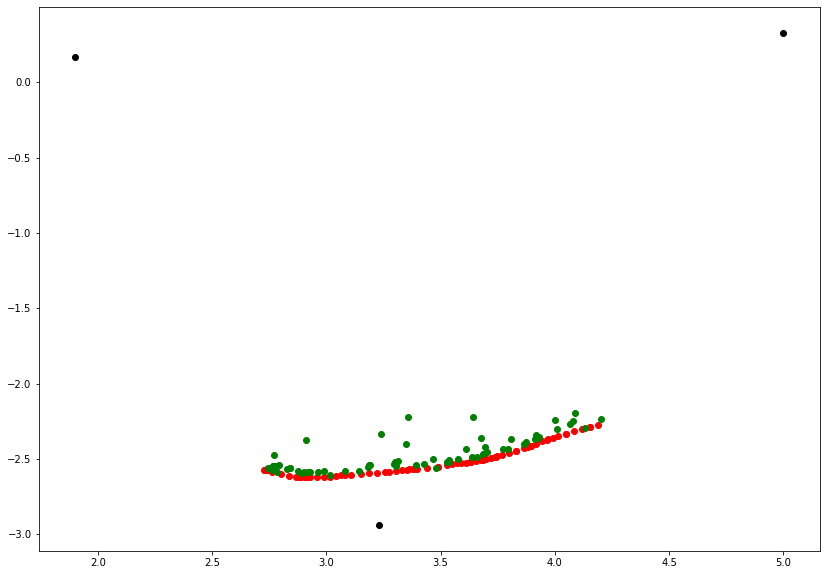

In [248]:
true_pos = np.array(y_feature_5)
predict_pos = np.array(predict_pos)
plt.figure(figsize=(14,10))
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black')
plt.scatter(true_pos[:100,0],true_pos[:100,1],c='red')
plt.scatter(rm_outlier[:,0],rm_outlier[:,1],c='green')
#plt.scatter(predict_pos[:50,0],predict_pos[:50,1],c='green')
plt.show()

In [244]:
x_list = [x_feature_1,x_feature_2,x_feature_3,x_feature_4,x_feature_5,x_feature_6,x_feature_7,x_feature_8]
y_list = [y_feature_1,y_feature_2,y_feature_3,y_feature_4,y_feature_5,y_feature_6,y_feature_7,y_feature_8]
x_data = x_feature_1+x_feature_2+x_feature_3+x_feature_4+x_feature_5+x_feature_6+x_feature_7+x_feature_8
y_data = y_feature_1+y_feature_2+y_feature_3+y_feature_4+y_feature_5+y_feature_6+y_feature_7+y_feature_8
x_scaler = preprocessing.StandardScaler().fit(x_data)
y_scaler = preprocessing.StandardScaler().fit(y_data)
test_index =  x_scaler.transform(x_feature_5[:1000])
predict_pos = y_scaler.inverse_transform(rf_model.predict(test_index)).tolist()

In [161]:
def dead_reckning(pos,acc,vol,time_period,eular):
    v_x = vol[0]
    v_y = vol[1]
    v_z = vol[2]
    alpha = eular[0]
    beta = eular[1]
    gama = eular[2]
    a_x = acc[0]
    a_y = acc[1]
    a_z = acc[2]
    
    trans = np.array([
    [1,0,0,time_period,0,0],
    [0,1,0,0,time_period,0],
    [0,0,1,0,0,time_period],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]])
    
    D = np.array([
    [0.5*time_period*time_period,0,0],
    [0,0.5*time_period*time_period,0],
    [0,0,0.5*time_period*time_period],
    [time_period,0,0],
    [0,time_period,0],
    [0,0,time_period]])
    
    Rot = np.array([
    [cos(alpha)*cos(gama),cos(alpha)*sin(gama)*sin(beta)-sin(alpha)*cos(beta),cos(alpha)*sin(gama)*cos(beta)+sin(alpha)*sin(beta)],
    [sin(alpha)*cos(gama),sin(alpha)*sin(beta)*sin(gama)+cos(alpha)*cos(beta),sin(alpha)*cos(beta)*cos(gama)-cos(alpha)*sin(beta)],
    [-sin(gama),cos(gama)*sin(beta),cos(gama)*cos(beta)]])
    
    x_pre = np.array([pos[0],pos[1],pos[2],v_x,v_y,v_z])
    U = [a_x,a_y,a_z]
    
    x_cur = np.dot(trans,x_pre)+np.dot(np.dot(D,Rot),U) 
    return x_cur[:3],x_cur[3:]   

In [ ]:
def predict_reck(index_end,pos,vol):
    
    acc = (df_merge_5.iloc[model1_t1[index_end],11]*0.01,df_merge_5.iloc[model1_t1[index_end],12]*0.01,df_merge_5.iloc[model1_t1[index_end],13]*0.01)
    time_period = df_merge_1.iloc[model1_t1[index_end],3]-df_merge_1.iloc[model1_t1[index_end]-1,3]
    eular = (df_merge_1.iloc[model1_t1[index_end],14],df_merge_1.iloc[model1_t1[index_end],15],df_merge_1.iloc[model1_t1[index_end],16])
    pos_,vol_ = dead_reckning(pos,acc,vol,time_period,eular)

    return pos_,vol_

In [127]:
period_start = file_5.get_T_index(8000000)

In [129]:
period_index = period_start[:100]

In [179]:
pos_init = [2.723,-2.560,0.940]
v_init= [-0.05,0.08,0.03]
acc = [-0.2,-0.4,-0.35]
euler = [66.94,87.31,177.81]
time_period = 0.12

In [181]:
dead_reckning(pos_init,acc,v_init,time_period,euler)

(array([ 2.71374058, -2.55046789,  0.9450463 ]),
 array([-0.10432372,  0.0788685 ,  0.05410492]))

In [218]:
outlier_detect = IsolationForest(behaviour='new', max_samples=10,
                      random_state=1, contamination='auto',n_estimators=2)
outlier_detect.fit(predict_pos[:100])

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
        max_features=1.0, max_samples=10, n_estimators=2, n_jobs=None,
        random_state=1, verbose=0)

In [220]:
outlier_detect.predict(predict_pos[10:20])

array([ 1, -1, -1, -1,  1,  1,  1, -1,  1,  1])

In [221]:
predict_pos[10:20]

array([[ 2.75479907, -2.5575437 ,  0.99735603],
       [ 2.85874476, -2.55198015,  0.84086003],
       [ 3.23709206, -2.33599806,  0.93325479],
       [ 3.17597139, -1.92293725,  0.91346094],
       [ 2.77358117, -2.54425806,  0.99746018],
       [ 2.7718722 , -2.55449112,  0.99661536],
       [ 2.7789191 , -2.55154509,  0.99485627],
       [ 2.9521556 , -2.44859389,  0.97593448],
       [ 2.83974869, -2.5579356 ,  0.99508773],
       [ 2.76484654, -2.55329824,  0.99553907]])

In [296]:
outlier_index = []
for i in range(10):
  
    
    outlier_detect = IsolationForest(behaviour='new', max_samples=10,
                      random_state=1, contamination='auto',n_estimators=6)

    
    outlier_detect.fit(predict_pos[i*10:(i+1)*10])
    outlier_index.extend(outlier_detect.predict(predict_pos[i*10:(i+1)*10]))

In [297]:
rm_outlier =[]
for index,item in enumerate(outlier_index):
    if item!=-1:
        rm_outlier.append(predict_pos[index])
rm_outlier = np.array(rm_outlier)

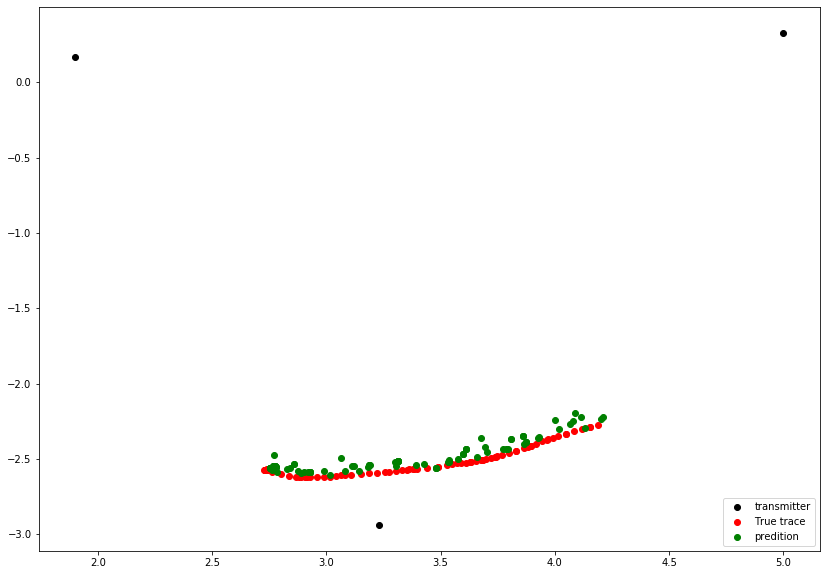

In [342]:
true_pos = np.array(y_feature_5)
predict_pos = np.array(predict_pos)
plt.figure(figsize=(14,10))
plt.scatter([1.90,5.00,3.23],[0.17,0.33,-2.94],c='black',label='transmitter')
plt.scatter(true_pos[:100,0],true_pos[:100,1],c='red',label='True trace')
plt.scatter(filter_result[:100,0],filter_result[:100,1],c='green',label='predition')
plt.legend(loc='lower right')
#plt.scatter(predict_pos[:50,0],predict_pos[:50,1],c='green')
plt.savefig('/Users/guoqiushi/Documents/sequence.png')
plt.show()

In [340]:
filter_result = []
previous = predict_pos[0]
for i in range(1,len(predict_pos)-1):
    if abs(predict_pos[i][0]-predict_pos[i-1][0])<0.1 and abs(predict_pos[i][1]-predict_pos[i-1][1])<0.1 and abs(predict_pos[i][2]-predict_pos[i-1][2])<0.1:
        filter_result.append(predict_pos[i])
    else:
        filter_result.append(previous)
    previous = filter_result[-1]
filter_result = np.array(filter_result)

In [349]:
filter_result[:10]

array([[ 2.77501553, -2.55550663,  0.99570109],
       [ 2.76552655, -2.55204439,  0.99069   ],
       [ 2.76079897, -2.56630349,  0.99746018],
       [ 2.76640645, -2.55071812,  0.99482155],
       [ 2.76569707, -2.54424942,  0.98471707],
       [ 2.76771822, -2.55523661,  0.99674266],
       [ 2.76773166, -2.549157  ,  0.99602514],
       [ 2.85708584, -2.53627708,  0.98391982],
       [ 2.85708584, -2.53627708,  0.98391982],
       [ 2.75479907, -2.5575437 ,  0.99735603]])

In [353]:
sequence_result = []
for i in range(100):
    sequence_result.append(math.sqrt(pow(true_pos[i][0]-filter_result[i][0],2)+pow(true_pos[i][1]-filter_result[i][1],2)+pow(true_pos[i][2]-filter_result[i][2],2)))

In [351]:
true_pos[:10]

array([[ 2.731 , -2.573 ,  0.936 ],
       [ 2.731 , -2.573 ,  0.936 ],
       [ 2.731 , -2.5737,  0.936 ],
       [ 2.731 , -2.574 ,  0.936 ],
       [ 2.7294, -2.5746,  0.936 ],
       [ 2.729 , -2.5742,  0.936 ],
       [ 2.7294, -2.573 ,  0.936 ],
       [ 2.7308, -2.5722,  0.936 ],
       [ 2.7316, -2.5726,  0.936 ],
       [ 2.733 , -2.573 ,  0.936 ]])

In [357]:
np.mean(sequence_result)

0.07950115867460403